In [2]:
paths_df

,name,path,type,description
0,flight_effects_folder,C:\Users\Marcos Quinones\phm2021_data_challeng...,folder,folder for the model and scalers used in the p...
1,flight_effects,C:\Users\Marcos Quinones\phm2021_data_challeng...,keras model,use model.load_model()
2,flight_effects_xscaler,C:\Users\Marcos Quinones\phm2021_data_challeng...,scaler,xscaler used for the flight effects model
3,flight_effects_yscaler,C:\Users\Marcos Quinones\phm2021_data_challeng...,scaler,yscaler used for the flight effects model
4,flight_effects_h5,C:\Users\Marcos Quinones\phm2021_data_challeng...,h5 model,same as keras model just in h5 format for red...
5,data_location,C:\Users\Marcos Quinones\phm2021_data_challeng...,folder,folder for all post-processed data
6,log_location,C:\Users\Marcos Quinones\phm2021_data_challeng...,folder,log folder
7,model_location,C:\Users\Marcos Quinones\phm2021_data_challeng...,folder,models folder
8,data_location,C:\Users\Marcos Quinones\phm2021_data_challeng...,folder,post processed data folder


In [1]:
import os
import sys
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import json
base_dir = os.path.dirname(os.getcwd())
print(base_dir)
sys.path.insert(1, base_dir)
from package.api import DB as api
import package.utils as utils
import package.tuning as tuning
utils.check_gpu()

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers, optimizers, metrics
#import tensorflow_addons as tfa

import keras_tuner as kt

from kerastuner_tensorboard_logger import (
    TensorBoardLogger,
    setup_tb  # Optional
)

from tqdm.notebook import tqdm, trange

%matplotlib inline
%load_ext autoreload
%autoreload 2


paths_df = pd.read_csv(base_dir + '/paths.csv')
paths_df['path'] = base_dir + '/' + paths_df['path']

Fc = 3
dataset = 'DS08'

log_location = base_dir + '/logs'
model_location = base_dir + '/models'
data_location = base_dir + '/data'
data_header = f'Fc-{Fc}_dataset-{dataset}'



params = {'datasource.username': 'macslab', # the username of the logged in user
            'datasource.password': 'Ch0colate!', 
            'datasource.database': 'ncmapss_db', # <- NO CHANGE 
            'datasource.url': '10.2.219.98', # <- or your database installation location
            'datasource.port': '5432'} # <- most likely don't change
db, cur =  api.connect(params)
db.set_session(autocommit=True)
del(params)


units_df = api._get_units(db=db)
units = units_df[(units_df['Fc'] == Fc) & (units_df['dataset'].str.contains(dataset))]


tables = ['summary_tb', 'telemetry_tb']
downsample=10
df = api._get_data(db=db,
                   units=pd.unique(units.id),
                   tables=tables,
                   downsample=downsample).astype(np.float32)
utils.add_time_column(units=pd.unique(units.id), df=df)
utils.add_rul_column(units=pd.unique(units.id), df=df)


W_cols = ['Mach', 'alt', 'TRA', 'T2', 'time']
Xs_cols = ['Wf', 'Nf', 'Nc', 'T24', 'T30', 'T48', 'T50', 'P15', 'P2', 'P21', 'P24', 'Ps30', 'P40', 'P50']
aux_cols = ['cycle', 'hs', 'Fc', 'asset_id']

In [63]:
model = keras.models.load_model(paths_df[paths_df['name']=='flight_effects_h5'].path.values[0])
type(model)

keras.engine.functional.Functional

In [64]:
yscaler = joblib.load(paths_df[paths_df['name']=='flight_effects_yscaler'].path.values[0])
xscaler = joblib.load(paths_df[paths_df['name']=='flight_effects_xscaler'].path.values[0])


trace = yscaler.transform(df[Xs_cols])
pred = model.predict(xscaler.transform(df[W_cols]))
res = trace - pred
dfx = pd.DataFrame(data=res, columns=Xs_cols)
df_x = pd.DataFrame(data=xscaler.transform(df[W_cols]), columns=W_cols)
dfx = pd.concat([dfx, df_x, df[aux_cols]], axis=1)
dfx['rul'] = df['rul'].values
dfx.time = dfx.time + (dfx.cycle -1)
dfx0 = dfx[dfx.hs == 0]

In [4]:
import time
tf.config.run_functions_eagerly(True)

@tf.function
def train_step(x,y):
    with tf.GradientTape() as tape:
        y_pred = model(x, training=True)
        loss = loss_fcn(y, y_pred)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_error_metric.update_state(y, y_pred)
    return loss
    
    
@tf.function
def val_step(x,y):
    y_pred = model(x, training=False)
    val_error_metric.update_state(y, y_pred)

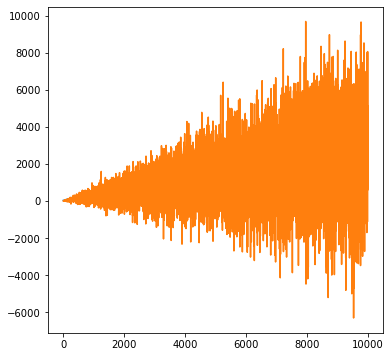

In [62]:
#### create X and y

length = 10000

x = np.arange(0, length)
y = .5*x**1 + 30

y_hat = .25*x * np.random.normal(1, 1, length)

# X = np.random.rand(length, 7).astype(np.float32)
# for i in range(length):
#     X[i][:] = X[i][:] * i
    
# X

fig = plt.figure(figsize=(6,6))
plt.plot(x, y)
plt.plot(x, y_hat)
plt.show()

In [20]:
X[:,0].shape

(10000,)

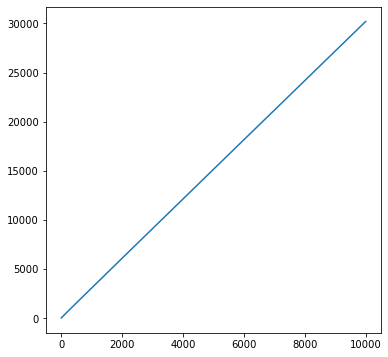

In [33]:
fig = plt.figure(figsize=(6,6))
plt.plot(x, y)
plt.show()

In [ ]:
####     define sequence range

min_seq_len = 300
max_seq_len = 1000

batch_size = 64
num_epochs = 20


####################################################
####            training objects
####################################################

optimizer = keras.optimizers.Adam(learning_rate=.001)
loss_fcn = keras.losses.MeanSquaredError()
train_error_metric = keras.metrics.RootMeanSquaredError()
val_error_metric = keras.metrics.RootMeanSquaredError()


####################################################
####            main training loop
####################################################

for epoch in range(num_epochs):
    start_time = time.time()
    
    ## get a random sequence length and number of batches
    seq_len = np.random.randint(min_seq_len, max_seq_len)
    num_batches = round((X.shape[0] - seq_len) / batch_size) + 1
    print(f"seq_len = {seq_len}, num_batches = {num_batches}")
    
    ## index counters for iterating the data and creating batches on the fly
    start = 0
    stop = seq_len + batch_size + start
    
    ## inner loop to iterate within an epoch
    for batch in tqdm(range(num_batches)):
        
        ## initialize the batches
        X_batch = []
        y_batch = []
        
        ## used to prevent the counters going beyond the length of the data
        break_signal = False
        
        ## inner loop to iterate within a batch
        for i in range(batch_size):
            
            ## initialize the samples
            X_sample = []
            y_sample = []
            
            ## builds X_sample
            for j in range(seq_len):
                _x = X[start:stop]
                if i+j < len(_x):
                    X_sample.append(_x[i+j])

            ## builds y_sample, prevents index out of range
            for j in range(seq_len, seq_len+horizon):
                idx = (batch*batch_size)+i+j
                if idx < len(y):
                    y_sample.append(y[idx])
                else:
                    break_signal = True
        
            if break_signal:
                break
        
            ## adds the sample to the batch
            X_batch.append(X_sample)
            y_batch.append(y_sample)
            
        ## increments the counters for iterating over the data
        start = stop - seq_len
        stop = start + seq_len + batch_size
        
        ## converts the batches to np arrays
        X_batch = np.array(X_batch)
        y_batch = np.array(y_batch)
        
        ## there are some cases where the final batch is empty
        if len(y_batch) > 0:
            
            ## train step, uses the last batch of each epoch for validation
            if batch < num_batches - 1:
                loss = train_step(X_batch, y_batch)
                
    ## update the train error at the end of each epoch
    train_error = train_error_metric.result()
    print(f"training error on epoch {epoch}: {float(train_error)}")
    train_error_metric.reset_states()
    
    ## update the validation error at the end of each epoch
    val_step(X_batch, y_batch)
    
    val_error = val_error_metric.result()
    print(f"validation error on epoch {epoch}: {float(val_error)}")
    val_error_metric.reset_states()
    print(f"elapsed time: {time.time() - start_time}")